In [67]:
# import necessary libraries
import pandas as pd

In [68]:
data = pd.read_csv('df_merged_weekly.csv', index_col=0)
data['dt'] = pd.to_datetime(data['dt'])
data.head()

,week,dt,Cases,temp,feels_like,pressure,humidity,precipitation
0,2022-1,2022-01-01,7.0,298.38,299.64,1013.0,87.0,3.14
1,2022-2,2022-01-08,1.0,302.23,308.88,1011.0,68.0,0.00
2,2022-3,2022-01-15,2.0,300.74,304.09,1013.0,58.0,0.00
3,2022-4,2022-01-22,3.0,302.42,309.89,1010.0,63.0,0.00
4,2022-5,2022-01-29,3.0,303.37,308.69,1010.0,64.0,0.42


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 0 to 139
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   week           140 non-null    object        
 1   dt             140 non-null    datetime64[ns]
 2   Cases          140 non-null    float64       
 3   temp           140 non-null    float64       
 4   feels_like     140 non-null    float64       
 5   pressure       140 non-null    float64       
 6   humidity       140 non-null    float64       
 7   precipitation  140 non-null    float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 9.8+ KB


# Columns
| column        | description                             | type     |
|---------------|-----------------------------------------|----------|
| week          | week corresponding to the specific year | datetime | 
| dt            | specific date                           | datetime |
| Cases         | Dengue Cases                            | integer  |
| temp          | Average temperature in the given week   | numeric  |
| feels_like    | Average feels_life in the given week    | numeric  |
| pressure      | Average pressure in the given week      | numeric  |
| humidity      | Average humidity in the given week      | numeric  |
| precipitation | Total precipitation in the given week   | numeric  |

## Training data
Data used to be trained range from 2022 to 2023

## Testing data
Data used to be tested is 2024 (also used for training)

In [236]:
# Training the rf model
# defining a function for general looping of n-week aheads
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def train_rf(data, features, target, date_col, n_ahead):
    # Select relevant columns
    rel_col = features + [target] + [date_col]
    data = data[rel_col]
    
    # Getting the first and last index for the year 2024
    first_2024 = data[data['dt'].dt.year == 2024].index[0]  # First index of 2024
    last_2024 = data[data['dt'].dt.year == 2024].index[-1]  # Last index of 2024
    
    first_2024subn = first_2024 - n_ahead # Subtract n_ahead weeks from first date of 2024
    last_2024subn = last_2024 - n_ahead  # Subtract n_ahead weeks from last date of 2024
    
    # Define lags
    env_lags = [2]   #2-week lag for environment features
    cases_lag = range(1, 12)  # 1 to 11 week lags for target variable
    
    # Create lagged features for environment and target variables
    for lag in env_lags:
        for feature in features:
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
    
    for lag in cases_lag:
        data[f'{target}_lag_{lag}'] = data[target].shift(lag)
    
    # Remove any rows with missing values due to lagging
    data = data.dropna()
    
    # Initialize list for storing predictions
    predict_data = []
    
    # Loop through data to get n-week ahead prediction
    index_begin = first_2024subn
    index_end = last_2024subn
    
    while index_begin <= index_end:
        rf = RandomForestRegressor(n_estimators=300)  # RandomForestRegressor with 100 estimators (can be tuned)
        
        # Split data into training and testing sets
        train_data = data[data.index <= index_begin]  # All rows up to index_begin
        test_data = data.iloc[data.index.get_loc(index_begin):data.index.get_loc(index_begin) + n_ahead]  # Next n_ahead rows
        
        X_train = train_data.drop(columns=[target, date_col])  # Drop target and date column for training data
        y_train = train_data[target]
        X_test = test_data.drop(columns=[target, date_col])  # Drop target and date column for test data
        y_test = test_data[target]
        
        # Fit the RandomForest model
        rf.fit(X_train, y_train)
        
        # Get the last prediction (n-week ahead prediction)
        predict_data.append(rf.predict(X_test)[-1])
        
        # Increment the index to the next week
        index_begin += 1
    MAE = mean_absolute_error(predict_data, data[data['dt'].dt.year == 2024]['Cases'])
    return predict_data, MAE




In [237]:
# Perform Initial Testing
target="Cases"
features=["temp","humidity","precipitation"]
date = 'dt'
prediction_1_week, MAE_1_week = train_rf(data, features, target, date, 1)
prediction_4_week, MAE_4_week = train_rf(data, features, target, date, 4)
prediction_12_week, MAE_12_week = train_rf(data, features, target, date, 12)

In [238]:
print(f'The Mean Absolute Error of the 1-Week Ahead Model is {MAE_1_week}')
print(f'The Mean Absolute Error of the 4-Week Ahead Model is {MAE_4_week}')
print(f'The Mean Absolute Error of the 12-Week Ahead Model is {MAE_12_week}')

The Mean Absolute Error of the 1-Week Ahead Model is 13.594537037037036
The Mean Absolute Error of the 4-Week Ahead Model is 21.96712962962963
The Mean Absolute Error of the 12-Week Ahead Model is 22.30342592592593


In [203]:
prediction_1_week[:5]

[np.float64(19.88),
 np.float64(17.99),
 np.float64(16.11),
 np.float64(20.52),
 np.float64(21.62)]

In [204]:
prediction_4_week[:5]

[np.float64(29.92),
 np.float64(27.83),
 np.float64(13.77),
 np.float64(13.2),
 np.float64(21.46)]

# Visualization

In [205]:
import matplotlib.pyplot as plt
first_2024 = int((data['dt'].dt.year==2024).idxmax())
last_2024 = int(data.loc[data['dt'].dt.year == 2024].index[-1])
date = data.loc[first_2024:last_2024]['dt']

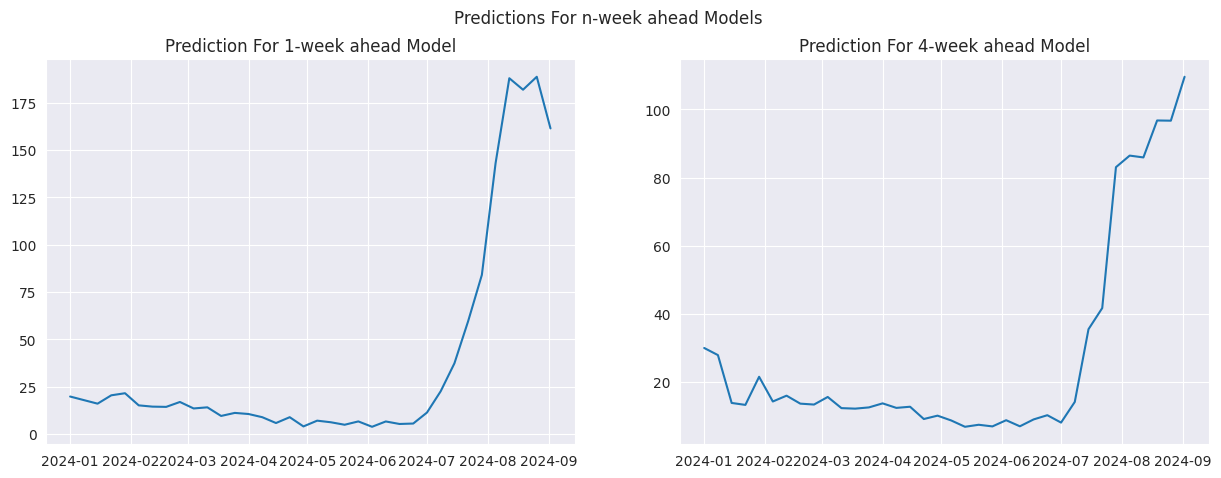

In [206]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(date,prediction_1_week)
ax[0].set_title('Prediction For 1-week ahead Model')
ax[1].plot(date,prediction_4_week)
ax[1].set_title('Prediction For 4-week ahead Model')
plt.suptitle('Predictions For n-week ahead Models')
plt.show()

Text(0.5, 1.0, 'Actual Cases')

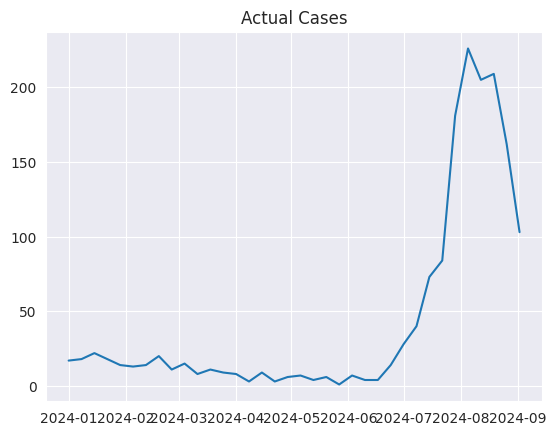

In [207]:
actual_2024 = data[data['dt'].dt.year == 2024]
plt.plot(actual_2024['dt'], actual_2024['Cases'])
plt.plot()
plt.title('Actual Cases')

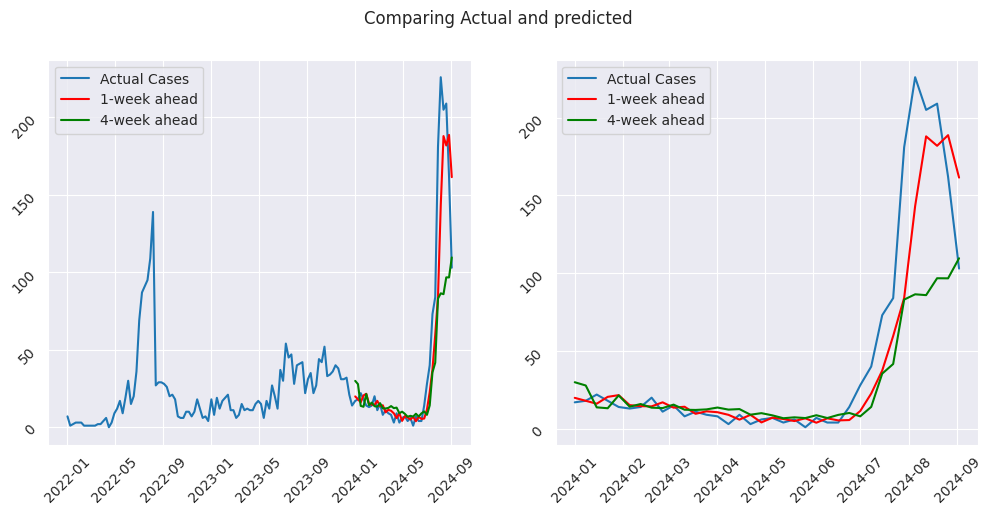

In [217]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(data['dt'], data['Cases'], label = 'Actual Cases')
ax[0].plot(date, prediction_1_week, color = 'red', label = '1-week ahead')
ax[0].plot(date, prediction_4_week, color = 'green', label = '4-week ahead')
ax[0].tick_params(labelrotation=45)
ax[0].legend()
ax[1].plot(actual_2024['dt'], actual_2024['Cases'], label = 'Actual Cases')
ax[1].plot(date, prediction_1_week, color = 'red', label = '1-week ahead')
ax[1].plot(date, prediction_4_week, color = 'green', label = '4-week ahead')
ax[1].tick_params(labelrotation=45)
ax[1].legend()
plt.suptitle('Comparing Actual and predicted')
plt.show()